# PRÁCTICA 1: PROCESAMIENTO PARALELO DE DATOS

## RUBÉN JOSÉ TENZA MARTÍN

### **TAREA 1: PROFILING DEL CÓDIGO**

El profiling del código lo realizaremos con la función scalene, ya que es un perfilador de alto rendimiento para CPU, GPU y memoria en Python. Es significativamente más rápido que otros perfiladores y proporciona información detallada. 

In [1]:
!pip install scalene


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    """
    Load an image and convert it to grayscale.
    """
    image = Image.open(image_path).convert('L')
    return np.array(image)

def apply_convolution(image, kernel):
    """
    Apply a convolution operation on the image with a given kernel.
    """
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Padding to keep the output size the same as the input size
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    # Initialize the output image
    output = np.zeros_like(image, dtype=float)

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output

def normalize_image(image):
    """
    Normalize an image to the range 0-255.
    """
    image = np.abs(image)
    return ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

def detect_edges(image):
    """
    Detect edges using the Sobel operator.
    """
    # Sobel kernels for detecting horizontal and vertical edges
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])

    # Apply convolution with Sobel kernels
    gradient_x = apply_convolution(image, sobel_x)
    gradient_y = apply_convolution(image, sobel_y)

    # Combine gradients to compute the edge intensity
    edges = np.sqrt(gradient_x**2 + gradient_y**2)

    return normalize_image(edges)

image_path = 'goldengate.jpg'
image = load_image(image_path)
t1 = time.time()
edges = detect_edges(image)
t2 = time.time()

# Display the original and edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Edge Detected Image')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.show()

print(f"El tiempo de ejecución de detect_edges() es: {t2-t1}")

FileNotFoundError: [Errno 2] No such file or directory: '/goldengate.jpg'

Como vemos arriba ese es código original, ahora le realizaremos un profiling con el objetivo de localizar las funciones que más tiempo de ejecución consumen.

In [ ]:
!scalene --cli code_sobel.py

Figure(1000x500)
             Memory usage: ▃▆█ (max: 30.892 MB, growth rate: 100%)             
/workspaces/procesamiento-paralelo/code_sobel.py: % of time = 100.00% (5.544s) 
                                out of 5.544s.                                 
       ╷       ╷       ╷       ╷        ╷       ╷               ╷       ╷      
       │Time   │–––––– │–––––– │Memory  │–––––– │–––––––––––    │Copy   │      
  Line │Python │native │system │Python  │peak   │timeline/%     │(MB/s) │/wo…  
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━┿━━━━━╸
     1 │       │       │       │        │       │               │       │# %%  
     2 │       │    6% │       │        │       │               │    18 │impo  
     3 │       │       │       │        │       │               │       │from  
     4 │   16% │   41% │   2%  │ 100%   │   20M │▂▄  65%        │   145 │impo  
     5 │       │       │       │        │       │               │       │      
     6 │       │       

### Ahora podemos analizar el resultado del profiling con el uso de **Scalene**:

### Funciones que más tiempo consumen:

#### 1.- *Apply Convolution*: 

Usa el 30% del tiempo el en Python, y en tiempo nativo 1%. Esta función usa bucles anidados para aplicar la convolución, lo cual es lento en Python puro. Como solución podríamos usar funciones que realizaran la convolución y evitar realizar los bucles anidados

#### 2.- *Detect Edges*: 

Usa un tiempo en python bajo, aunque el uso de memoria es del 97% (11MB), la mayor parte del consumo de memoria ocurre aquí, probablemente por las matrices temporales gradient_x, gradient_y y edges. Al llamar a la función apply convolution en la que se encuentran dichos bucles.

### Consumo de memoria:

#### 1.- *Línea 1* (**import numpy as np**): 

Consume 20MB ya que la carga inicial de numpy ocupa esa cantidad de memoria.

#### 2.- *Línea 61* (**edges = np.sqrt(gradient_x^2 + gradient_y^2)**): 

Consume 11MB ya que se crean varias matrices intermedias.

### **TAREA 2: PARALELIZAR FUNCIONES:**

Para la paralelización realizaremos la partición de la imagen en N bloques horizontales, por lo que se distribuirán esos bloques en los distintos procesos. La estrategia de bloques horizontales es la mejor porque:

Reduce la sobrecarga de comunicación entre procesos.

Mantiene una buena distribución del trabajo.

Puede escalar bien con más núcleos

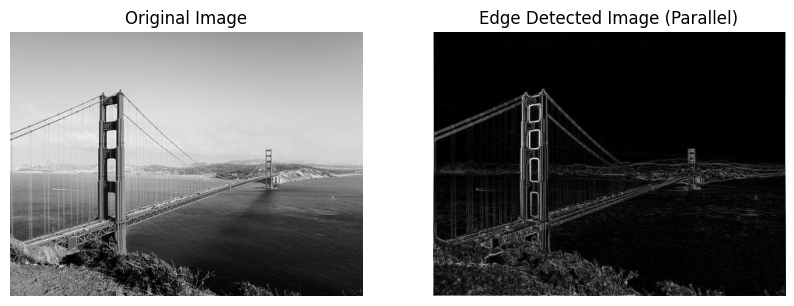

Tiempo paralelizando: 1.428715705871582


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import time

def load_image(image_path):
    image = Image.open(image_path).convert('L')
    return np.array(image)

def apply_convolution_block(args):
    """
    Apply convolution on a specific block of the image.
    """
    image, kernel, start_row, end_row = args
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    output = np.zeros((end_row - start_row, image.shape[1]), dtype=float)

    for i in range(start_row, end_row):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i - start_row, j] = np.sum(region * kernel)

    return output

def parallel_apply_convolution(image, kernel, num_processes=None):
    """
    Parallelize the convolution process by dividing the image into horizontal blocks.
    """
    if num_processes is None:
        num_processes = cpu_count()

    height, _ = image.shape
    chunk_size = height // num_processes

    chunks = [(image, kernel, i * chunk_size, (i + 1) * chunk_size if i < num_processes - 1 else height)
              for i in range(num_processes)]

    with Pool(processes=num_processes) as pool:
        results = pool.map(apply_convolution_block, chunks)

    return np.vstack(results)

def normalize_image(image):
    image = np.abs(image)
    return ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

def detect_edges(image, num_processes=None):
    """
    Detect edges using the Sobel operator with multiprocessing.
    """
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = parallel_apply_convolution(image, sobel_x, num_processes)
    gradient_y = parallel_apply_convolution(image, sobel_y, num_processes)

    edges = np.sqrt(gradient_x**2 + gradient_y**2)
    return normalize_image(edges)

# Load and process image
image_path = './goldengate.jpg'
image = load_image(image_path)

# Detect edges with multiprocessing
t1 = time.time()
edges = detect_edges(image)
t2 = time.time()
# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Edge Detected Image (Parallel)')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.show()

print(f"Tiempo paralelizando: {t2-t1}")